In [1]:
import numpy as np
import matplotlib.pyplot as plt
import _pickle as pkl
import pandas as pd
import os,io,sys,glob, h5py, csv, time
import matplotlib.pyplot as plt
import json


from scipy.stats import pearsonr, spearmanr, zscore
from itertools import combinations 

from sklearn.manifold import TSNE
from scipy.cluster.vq import kmeans2

from scipy import stats
from scipy.ndimage.filters import gaussian_filter1d

import seaborn as sns
sns.set_style('white')
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set_style("white")
import warnings
warnings.filterwarnings('ignore')

In [306]:
# some functions

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def countlist(lst): #to count consecutive numbers in movement-related code
    streak_count = []
    inds = []
    ups = []
    downs = []
    counter = 1
    for i in range(len(lst)):
        if i != (len(lst) - 1):
            diff = lst[i+1] - lst[i]
            if diff == 1:
                counter += 1
                inds.append(lst[i])
            else:
                streak_count.append(counter)
                counter = 1
                if inds!=[]:
                    ups.append(np.min(inds))
                    downs.append(np.max(inds))
                    inds = []
        else:
            streak_count.append(counter)
    return(streak_count,ups,downs)

# load files - fill in files

In [2]:
file1 = 
file2 = 
file3 = 

In [3]:
move = np.loadtxt(file3)
flu = np.load(file1)
cells = np.load(file2)

In [210]:
axons_tens = np.zeros((168,np.shape(flu)[1]))

In [214]:
# creates list of axon ROIs that we filtered as "cells" in suite2p
# iscells.npy is a list of cells (1) and not cells (0) as classified in suite2p, this loop makes list of only cells, called axons
axons = []
for i,cell in enumerate(cells):
    if cell[0]>0:
        axons.append(flu[i])

# "synch" time for axons and movement

In [7]:
#convert to time
total_time = (1/8*np.shape(axons[0])[0])
FR = 1/8 #sampling rate of 2P
t_axons = np.arange(0,total_time,FR)

In [8]:
#convert to time
total_time = np.shape(move)[0]*(1/42)
FR = 1/42 # sampling rate of arduino
t_move = np.arange(0,total_time,FR)

In [9]:
move_diff = np.diff(move)

(23770,)

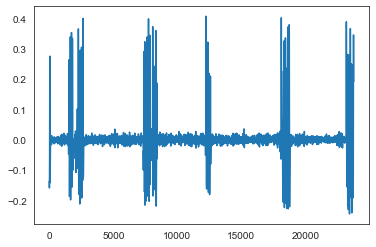

In [10]:
smooth_move = gaussian_filter1d(move_diff, sigma=8)

# find movement epochs

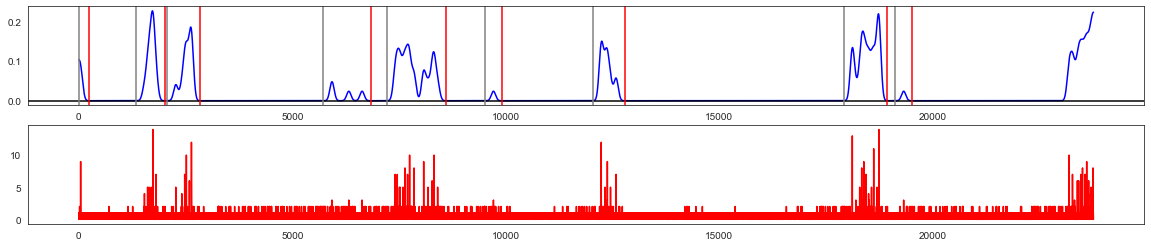

In [278]:
#unit_ser = pd.Series(gaussian_filter1d(mv,sigma=50))
smoothed_move = pd.Series(gaussian_filter1d(mv,sigma=50))
#rolave_unit = unit_ser.rolling(400).sum() #takes sum of 100bins, shifts 1bin .. 100 bins binned at 1 ms = 100ms summed bins
#rolave_unit = np.array(rolave_unit.dropna())
#olave_unit = gaussian_filter1d(rolave_unit, sigma=3)
#mn = np.mean(rolave_unit)
#std = np.std(rolave_unit)
thresh = 0
cross = np.where(rolave_unit>thresh)
streaks,ups,downs = countlist(cross[0])
fig,(ax1,ax2) = plt.subplots(2,figsize=(20,4))
ax1.plot(rolave_unit,c='b')
ax2.plot(np.abs(np.diff(move)),c='r')
ax1.axhline(thresh,c='black')
for v in ups:
    ax1.axvline(v,c='gray')
for d in downs:
    ax1.axvline(d,c='r')

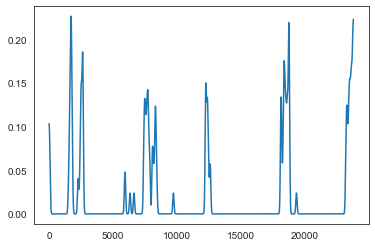

In [294]:
smoothed_move = pd.Series(gaussian_filter1d(mv,sigma=50))
plt.plot(smoothed_move)

In [32]:
# convert to axon time
t_ups = t_move[ups]
up_move = []
for t in t_ups:
    t_a = find_nearest(t_axons,t)
    this = np.where(t_axons==t_a)
    this = this[0][0]
    up_move.append(this)

In [144]:
# convert to axon time
t_downs = t_move[downs]
down_move = []
for t in t_downs:
    t_a = find_nearest(t_axons,t)
    this = np.where(t_axons==t_a)
    this = this[0][0]
    down_move.append(this)

# normalize fluorescence

In [243]:
# this gives you new list of normalized fluorescence named dfs
dfs = [] # initialize new list
for i,axon in enumerate(axons):
    fmin = np.min(axon)
    fmax = np.max(axon)
    df = (axon-fmin)/fmax # this is a shitty way to normalize but good enough for now
    #mn = np.mean(axons[i])
    #df = (axon-mn)/mn
    dfs.append(df) #append each normalized axon fluoresc. to new list

# plot the normalized flourescence for each axon

# add a vertical line to each above plot at movement onset

# plot a heatmap of the normalized fluorescence for each axon

# find up-modulated units

In [405]:
up_mod = []
down_mod = []
framebefore = 30
frameafter = 30
epochs_all = []
for axon in dfs:
    epochs = []
    for t in up_move[1:-1]:
        #time_axon = t_axons[t]
        a = t-framebefore
        b = t+frameafter
        #fig,(ax1,ax2) = plt.subplots(2)
        #base = axon[a:t]
        #ep = axon[t:b]
        #df = (ep-base)/base
        epoch = axon[a:b]
        #epoch = df
        epochs.append(epoch)
    mn = np.mean(epochs,axis=0)
    #for ugh in epochs:
    #    ax1.plot(ugh)
    md_b=np.median(mn[:framebefore])
    #df = (mn-md_b)/md_b
    #mn_ = np.mean(df[:20])+(2.5*np.std(df[:20]))
    epochs_all.append(list(mn))
    
    meanbinfr_b = mn[:framebefore]
    mfrb_ser = pd.Series(meanbinfr_b)        
    rolave_mfrb = mfrb_ser.rolling(5).sum() #takes sum of 100bins, shifts 1bin .. 100 bins binned at 1 ms = 100ms summed bins
    rolave_mfrb = np.array(rolave_mfrb.dropna())
    #lower,upper = sms.DescrStatsW(rolave_mfrb).tconfint_mean() #fix this
    upper = np.mean(rolave_mfrb) + (2.56*np.std(rolave_mfrb))
    lower = np.mean(rolave_mfrb) - (2.56*np.std(rolave_mfrb))
    
    meanbinfr_e = mn[framebefore:]
    mfr_ser = pd.Series(meanbinfr_e)        
    rolave_mfr = mfr_ser.rolling(5).sum() #takes sum of 100bins, shifts 1bin
    
    mfr_a = np.array(rolave_mfr)
    up = np.where(mfr_a >= upper)[0].tolist()
    down = np.where(mfr_a <= lower)[0].tolist()

    consec_up,na,nao = countlist(up)
    consec_down,na,nao = countlist(down)
    consec_up = np.array(consec_up)
    consec_down = np.array(consec_down)

    if any(consec_up >= 5): #if there are 5 consecutive bins
        ups = 'yes'
        up_mod.append(ups)
    else:
        ups = 'no'
        up_mod.append(ups)

    if any(consec_down >= 5): #if there are 5 consecutive bins
        downs = 'yes'
        down_mod.append(downs)
    else:
        downs = 'no'
        down_mod.append(downs)

In [406]:
axons_df = []
for i,ax in enumerate(dfs):
    axons_df.append(list(ax))

In [407]:
df = pd.DataFrame(data=up_mod,columns=['up_mod'])
#df['up_mod'] = up_mod
df['fluor'] = axons_df
df['up_mod'] = up_mod
df['ave_axon'] = epochs_all

df_up = df[df.up_mod=='yes']
df_noup = df[df.up_mod!='yes']

# using the above dataframe that was just created, plot the average fluorescence for up-mod units and non-mod units (you can pick timeframe). aka: replicate below figure in which blue line is the average trace for modulated units and orange line = non-mod units

hints:

In [ ]:
df[df.up_mod=='yes']

In [ ]:
df[df.up_mod=='yes'].ave_axon

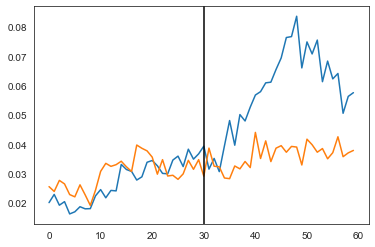

In [410]:
# make this

# make a pie chart with number of modulated and non-modulated axons

hints:

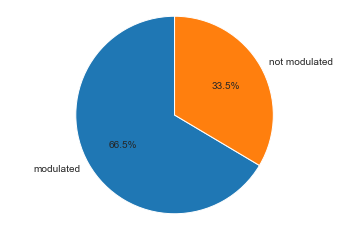

<function matplotlib.pyplot.close(fig=None)>

In [389]:
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)


# make 2 plots using plt.subplots with the top plot = each axon's fluorescence value and the 2nd plot = movement (example below)

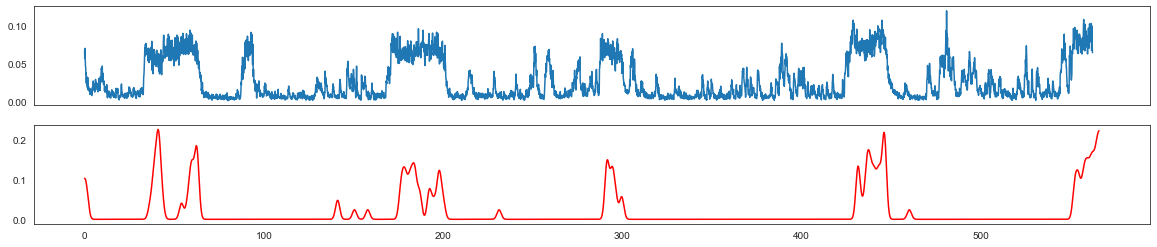